In [55]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# 1.) Dataset

In [56]:
# Baca Datasets
data = pd.read_csv("/content/tweet.csv")

In [57]:
data.head()

,Unnamed: 0,sentimen,tweet
0,0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa ...
1,1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib..."
2,2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik...."
3,3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p..."
4,4,negatif,Negara kita ngutang buat bngun infrastruktur y...


In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1815 entries, 0 to 1814
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1815 non-null   int64 
 1   sentimen    1815 non-null   object
 2   tweet       1815 non-null   object
dtypes: int64(1), object(2)
memory usage: 42.7+ KB


In [59]:
data.isnull().sum()

Unnamed: 0    0
sentimen      0
tweet         0
dtype: int64

In [60]:
data['sentimen'].value_counts()

positif    612
netral     607
negatif    596
Name: sentimen, dtype: int64

# 2.) Natural Language Text Preprocessing

## Text Cleaning

### Stopwords, Punctuation, Case Folding

In [61]:
%%time

import re
import string
import pandas as pd

def clean_text(text):
    # Menghapus username Twitter (@username)
    text = re.sub(r'@\w+', '', text)

    # Menghapus URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Menghapus karakter non-alfanumerik dan tanda baca
    text = re.sub(r'[^\w\s]', '', text)

    # Menghapus karakter berulang
    text = re.sub(r'(.)\1+', r'\1\1', text)

    # Mengubah ke lowercase
    text = text.lower()

    return text

def remove(tweet):
    # Remove mention
    tweet = re.sub("@[A-Za-z0-9_]+", "", tweet)
    # Remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # Remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    tweet = re.sub(r'^rt[\s]+', '', tweet)
    # Remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    tweet = re.sub(r'^https[\s]+', '', tweet)
    # Remove hashtags
    tweet = re.sub(r'#', '', tweet)
    tweet = re.sub(r'%', '', tweet)
    # Remove commas
    tweet = re.sub(r',', '', tweet)
    # Remove numbers
    tweet = re.sub('[0-9]+', '', tweet)
    tweet = re.sub(r':', '', tweet)
    # Remove space
    tweet = tweet.strip()
    # Remove double space}
    tweet = re.sub('\s+', ' ', tweet)
    # Menghapus angka
    tweet = re.sub(r'\d+', '', tweet)

    # Menghapus tanda baca
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))

    # Cleaning text
    cleaned_tweet = clean_text(tweet)

    return cleaned_tweet

# Menerapkan fungsi remove dan clean_text pada kolom 'tweet' dan menyimpan hasilnya dalam kolom 'cleaning_data'
data['tweet_clean'] = data['tweet'].apply(lambda x: remove(x.lower()))

# Menampilkan hasil
print(data['tweet_clean'])

0       kata indonesia tidak dihargai bangsa asing ber...
1       batuan langka tasbih jokowi hadiah dari habib ...
2       di era jokowi ekonomi indonesia semakin baik i...
3       bagi sumatera selatan asian games berdampak pd...
4       negara kita ngutang buat bngun infrastruktur y...
                              ...                        
1810    negarawan sejati sll bangga dan mengedepankan ...
1811     hrs ceramah di damai indonesiaku  perekonomia...
1812    mari bangun bangsa dgn mendukung perekonomian ...
1813    bantu majukan perekonomian bangsa bersama pak ...
1814    pak mengubah cara pandang ekonomi kini semua o...
Name: tweet_clean, Length: 1815, dtype: object
CPU times: user 134 ms, sys: 0 ns, total: 134 ms
Wall time: 136 ms


## Stopword Removal

In [62]:
# Download stopwords
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### Stopword Tradisional

In [63]:
%%time

import re
import pandas as pd

def remove_stopwords(text):
    stopwords = ['yg','ðŸ','ðÿœ',"yg", "dg", "rt", "dgn", "ny", "d", 'klo',
                       'kalo', 'amp', 'biar', 'bikin', 'bilang',
                       'gak', 'ga', 'krn', 'nya', 'nih', 'sih',
                       'si', 'tau', 'tdk', 'tuh', 'utk', 'ya',
                       'jd', 'jgn', 'sdh', 'aja', 'n', 't',
                       'nyg', 'hehe', 'pen', 'u', 'nan', 'loh', 'rt',
                       '&amp', 'yah']  # Ganti dengan stopwords tradisional sesuai kebutuhan

    # Menghapus karakter non-alfabet dan mengubah teks menjadi huruf kecil
    processed_text = re.sub(r'[^a-zA-Z]', ' ', text.lower())

    # Memisahkan kata-kata dalam teks
    words = processed_text.split()

    # Menghapus stopwords dari teks
    filtered_words = [word for word in words if word not in stopwords]

    # Menggabungkan kembali kata-kata yang telah di-filter
    filtered_text = ' '.join(filtered_words)

    return filtered_text

 #Menerapkan fungsi remove_stopwords pada kolom 'tweet_clean'
filtered_text = data['tweet_clean'].apply(remove_stopwords)

 #Menampilkan DataFrame hasil
print(filtered_text)


0       kata indonesia tidak dihargai bangsa asing ber...
1       batuan langka tasbih jokowi hadiah dari habib ...
2       di era jokowi ekonomi indonesia semakin baik i...
3       bagi sumatera selatan asian games berdampak pd...
4       negara kita ngutang buat bngun infrastruktur y...
                              ...                        
1810    negarawan sejati sll bangga dan mengedepankan ...
1811    hrs ceramah di damai indonesiaku perekonomian ...
1812    mari bangun bangsa mendukung perekonomian nega...
1813    bantu majukan perekonomian bangsa bersama pak ...
1814    pak mengubah cara pandang ekonomi kini semua o...
Name: tweet_clean, Length: 1815, dtype: object
CPU times: user 55.8 ms, sys: 869 µs, total: 56.6 ms
Wall time: 58.6 ms


### Stopword Sastrawi

In [64]:
%%time
!pip install Sastrawi
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import re

def preprocess_text(text):
    # Buat instance dari StopWordRemoverFactory
    factory = StopWordRemoverFactory()
    stopword_remover = factory.create_stop_word_remover()

    # Menghapus karakter non-alfanumerik dan mengubah ke huruf kecil
    text = re.sub(r'\W+', ' ', text.lower())

    # Menghapus stopwords dari teks menggunakan Sastrawi
    text_tanpa_stopword = stopword_remover.remove(text)

    return text_tanpa_stopword

data['tweet_sw'] =filtered_text.apply(preprocess_text)

print(data['tweet_sw'])

0       kata indonesia dihargai bangsa asing berita pa...
1       batuan langka tasbih jokowi hadiah habib luthf...
2       era jokowi ekonomi indonesia semakin baik indo...
3       sumatera selatan asian games berdampak pd ekon...
4       negara ngutang buat bngun infrastruktur udah d...
                              ...                        
1810    negarawan sejati sll bangga mengedepankan harg...
1811    hrs ceramah damai indonesiaku perekonomian mak...
1812    bangun bangsa mendukung perekonomian negara be...
1813    bantu majukan perekonomian bangsa bersama pak ...
1814    pak mengubah cara pandang ekonomi kini semua o...
Name: tweet_sw, Length: 1815, dtype: object
CPU times: user 185 ms, sys: 10.1 ms, total: 195 ms
Wall time: 4.57 s


## Text Normalization

### Lemmazation

In [65]:
%%time
import spacy
nlp = spacy.load('en_core_web_sm')

def lemmatization (text):
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct]
    return ' '.join(tokens)
data['tweet_clean'] = data['tweet_sw'].apply(lemmatization)

CPU times: user 28.5 s, sys: 176 ms, total: 28.7 s
Wall time: 43.1 s


In [66]:
data['tweet_clean']

0       kata indonesia dihargai bangsa ase berita past...
1       batuan langka tasbih jokowi hadiah habib luthf...
2       era jokowi ekonomi indonesia semakin baik indo...
3       sumatera selatan asian game berdampak pd ekono...
4       negara ngutang buat bngun infrastruktur udah d...
                              ...                        
1810    negarawan sejati sll bangga mengedepankan harg...
1811    hrs ceramah damai indonesiaku perekonomian mak...
1812    bangun bangsa mendukung perekonomian negara be...
1813    bantu majukan perekonomian bangsa bersama pak ...
1814    pak mengubah cara pandang ekonomi kini semua o...
Name: tweet_clean, Length: 1815, dtype: object

## Text Tokenization

### Word Tokenization

In [67]:
%%time
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

# Fungsi untuk tokenisasi kata
def tokenize_words(text):
    words = word_tokenize(text)
    return words

# Tokenisasi kata
data['tweet_token_words'] = data['tweet_clean'].apply(tokenize_words)
print("\nTokenisasi kata:")
print(data['tweet_token_words'])


Tokenisasi kata:
0       [kata, indonesia, dihargai, bangsa, ase, berit...
1       [batuan, langka, tasbih, jokowi, hadiah, habib...
2       [era, jokowi, ekonomi, indonesia, semakin, bai...
3       [sumatera, selatan, asian, game, berdampak, pd...
4       [negara, ngutang, buat, bngun, infrastruktur, ...
                              ...                        
1810    [negarawan, sejati, sll, bangga, mengedepankan...
1811    [hrs, ceramah, damai, indonesiaku, perekonomia...
1812    [bangun, bangsa, mendukung, perekonomian, nega...
1813    [bantu, majukan, perekonomian, bangsa, bersama...
1814    [pak, mengubah, cara, pandang, ekonomi, kini, ...
Name: tweet_token_words, Length: 1815, dtype: object
CPU times: user 498 ms, sys: 4 ms, total: 502 ms
Wall time: 1.19 s


### Sentence Tokenization

In [68]:
%%time
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

# Fungsi untuk tokenisasi kalimat
def tokenize_sentences(text):
    sentences = sent_tokenize(text)
    return sentences

# Tokenisasi kalimat
data['tweet_token_sentences'] = data['tweet_clean'].apply(tokenize_sentences)
print("Tokenisasi kalimat:")
print(data['tweet_token_sentences'])

Tokenisasi kalimat:
0       [kata indonesia dihargai bangsa ase berita pas...
1       [batuan langka tasbih jokowi hadiah habib luth...
2       [era jokowi ekonomi indonesia semakin baik ind...
3       [sumatera selatan asian game berdampak pd ekon...
4       [negara ngutang buat bngun infrastruktur udah ...
                              ...                        
1810    [negarawan sejati sll bangga mengedepankan har...
1811    [hrs ceramah damai indonesiaku perekonomian ma...
1812    [bangun bangsa mendukung perekonomian negara b...
1813    [bantu majukan perekonomian bangsa bersama pak...
1814    [pak mengubah cara pandang ekonomi kini semua ...
Name: tweet_token_sentences, Length: 1815, dtype: object
CPU times: user 62.3 ms, sys: 520 µs, total: 62.8 ms
Wall time: 72.7 ms


## Word2Vec

### CBOW

In [69]:
import gensim
from gensim.models import Word2Vec

# WORD2VEC
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

In [70]:
%%time
clean_data = data['tweet_clean'].apply(gensim.utils.simple_preprocess)

CPU times: user 78.4 ms, sys: 844 µs, total: 79.2 ms
Wall time: 99 ms


In [71]:
w2v_model = Word2Vec(vector_size=W2V_SIZE,
                     window=W2V_WINDOW,
                     min_count=W2V_MIN_COUNT,
                     workers=8)

In [72]:
w2v_model.build_vocab(clean_data)

In [73]:
words = list(w2v_model.wv.key_to_index.keys())
vocab_size = len(words)
print("Vocab size:", vocab_size)

Vocab size: 599


In [74]:
%%time
w2v_model.train(clean_data, total_examples=len(clean_data), epochs=W2V_EPOCH)

CPU times: user 2.26 s, sys: 45 ms, total: 2.31 s
Wall time: 2.55 s


(485678, 1029728)

In [75]:
%%time
# Membuat objek Word2Vec (contoh)
sentences = [tweet.split() for tweet in data['tweet_clean']]
w2v_model = Word2Vec(sentences=sentences, min_count=1)

# Membuat kolom baru di DataFrame untuk menampung hasil append
data['tweet_w2v_model'] = data['tweet_clean'].apply(lambda x: w2v_model.wv[x.split()[0]] if len(x.split()) > 0 else [])

# Menampilkan DataFrame
print("tweet_w2v_model kalimat:")
print(data['tweet_w2v_model'])

tweet_w2v_model kalimat:
0       [-0.044002566, 0.11057298, 0.09935948, 0.02183...
1       [0.0009765492, 0.003546909, -0.0026024194, 0.0...
2       [-0.04418581, 0.10305963, 0.10472739, 0.032659...
3       [-0.0034292447, 0.019263756, 0.026686836, -0.0...
4       [-0.10296383, 0.2809709, 0.28539345, 0.0652127...
                              ...                        
1810    [7.47883e-05, -0.00045436286, 0.004150381, 0.0...
1811    [-0.010575513, 0.061955128, 0.052813776, 0.024...
1812    [-0.011223201, 0.051279087, 0.051146362, 0.009...
1813    [-0.0033647928, 0.0088891685, 0.012583562, -0....
1814    [-0.12316824, 0.3353954, 0.31270018, 0.0813933...
Name: tweet_w2v_model, Length: 1815, dtype: object
CPU times: user 652 ms, sys: 9.61 ms, total: 661 ms
Wall time: 481 ms


In [76]:
similar_words = w2v_model.wv.most_similar("ekonomi")
similar_words

[('rakyat', 0.9996941089630127),
 ('jokowi', 0.9996474981307983),
 ('indonesia', 0.9995330572128296),
 ('negara', 0.9994763135910034),
 ('harga', 0.999475359916687),
 ('pak', 0.9994721412658691),
 ('prabowo', 0.9994521141052246),
 ('orang', 0.9994275569915771),
 ('pajak', 0.9994259476661682),
 ('debat', 0.9994248151779175)]

## EDA

### Distribusi Dari Review per Sentimen






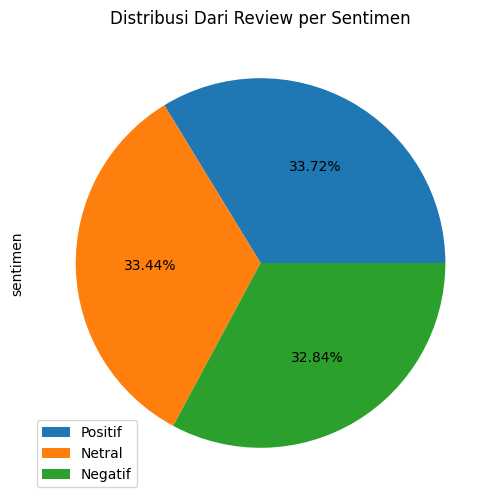

In [77]:
import matplotlib.pyplot as plt

data['sentimen'].value_counts().plot.pie(figsize=(6,6),title="Distribusi Dari Review per Sentimen",labels=['','',''],autopct='%1.2f%%')
labels=["Positif","Netral","Negatif"]
plt.legend(labels,loc=3)
plt.gca().set_aspect('equal')

### Visualizing Word Clouds

In [78]:
from wordcloud import WordCloud

In [79]:
data_negatif = data[data['sentimen'] == "positif"]
data_positif = data[data['sentimen'] == "negatif"]
data_netral = data[data['sentimen'] == "netral"]

# Menggabungkan semua list menjadi satu list tunggal
all_frekuensi_list = [word for sublist in data['tweet_token_words'] for word in sublist]
negative_list = [word for sublist in data_negatif['tweet_token_words'] for word in sublist]
positive_list = [word for sublist in data_positif['tweet_token_words'] for word in sublist]
netral_list = [word for sublist in data_netral['tweet_token_words'] for word in sublist]

filtered_all_frekuensi = " ".join(all_frekuensi_list)  # Mengubah list menjadi string
filtered_all_frekuensi = filtered_all_frekuensi.lower()

filtered_negative = " ".join(negative_list)  # Mengubah list menjadi string
filtered_negative = filtered_negative.lower()

filtered_positive = " ".join(positive_list)  # Mengubah list menjadi string
filtered_positive = filtered_positive.lower()

filtered_neutral = " ".join(netral_list)  # Mengubah list menjadi string
filtered_neutral = filtered_neutral.lower()


#### Word Cloud : Frekuensi Semua Ulasan

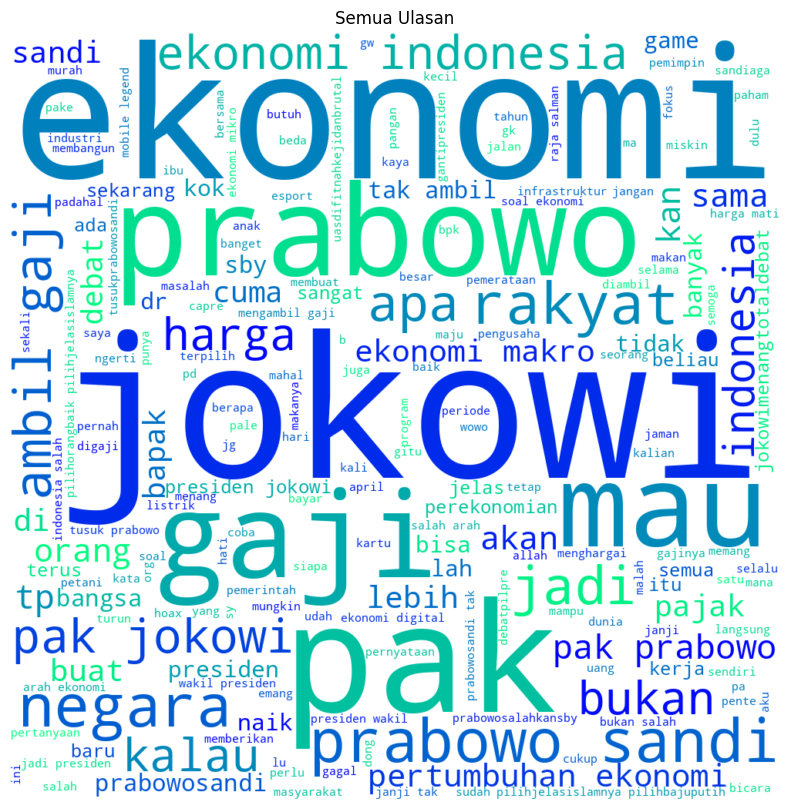

In [80]:
# Visualisasi frekuensi kemunculan kata

wordcloud = WordCloud(colormap='winter', width=1000, height=1000, mode='RGBA', background_color='white').generate(filtered_all_frekuensi)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Semua Ulasan")
plt.margins(x=0, y=0)
plt.show()

#### Word Cloud : Positive

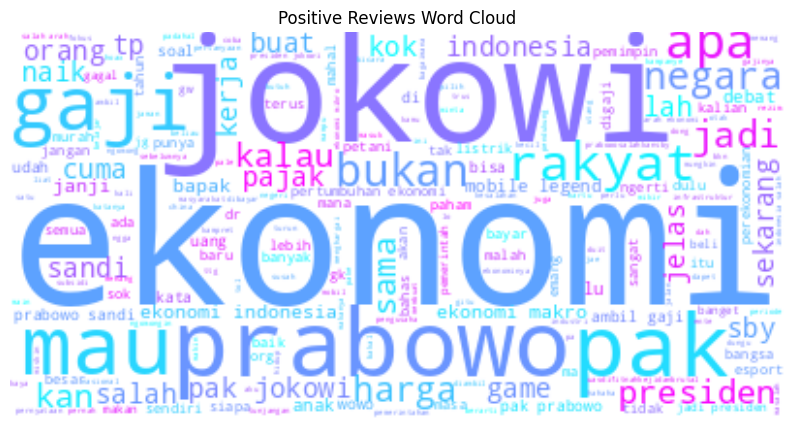

In [81]:
wordcloud = WordCloud(max_font_size = 160, margin=0, background_color = "white", colormap="cool").generate(filtered_positive)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.title("Positive Reviews Word Cloud")
plt.show()

#### Word Cloud : Negatif

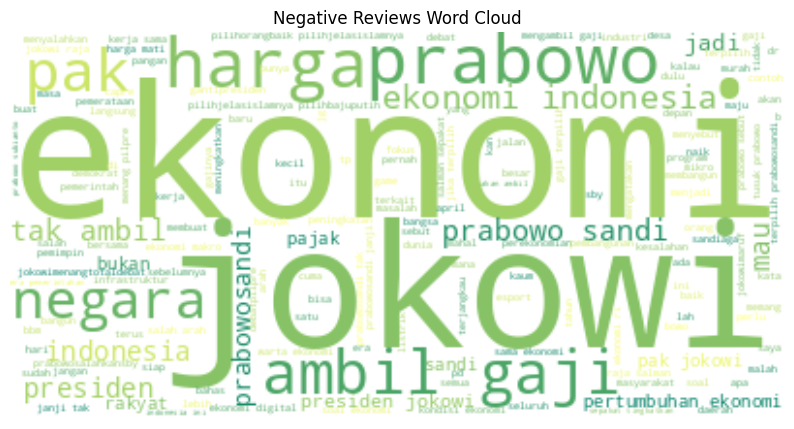

In [82]:
wordcloud = WordCloud(max_font_size = 160, margin=0, background_color = "white", colormap="summer").generate(filtered_neutral)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.title("Negative Reviews Word Cloud")
plt.show()

#### Word Cloud : Netral

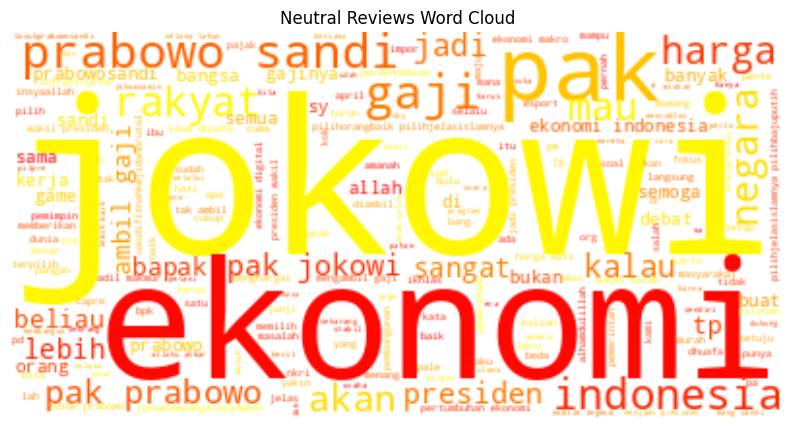

In [83]:
wordcloud = WordCloud(max_font_size = 160, margin=0, background_color = "white", colormap="autumn").generate(filtered_negative)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.title("Neutral Reviews Word Cloud")
plt.show()

## Data Final

In [118]:
data.head()

,Unnamed: 0,sentimen,tweet,tweet_clean,tweet_sw,tweet_token_words,tweet_token_sentences,tweet_w2v_model
0,0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa ...,kata indonesia dihargai bangsa ase berita past...,kata indonesia dihargai bangsa asing berita pa...,"[kata, indonesia, dihargai, bangsa, ase, berit...",[kata indonesia dihargai bangsa ase berita pas...,"[-0.044002566, 0.11057298, 0.09935948, 0.02183..."
1,1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib...",batuan langka tasbih jokowi hadiah habib luthf...,batuan langka tasbih jokowi hadiah habib luthf...,"[batuan, langka, tasbih, jokowi, hadiah, habib...",[batuan langka tasbih jokowi hadiah habib luth...,"[0.0009765492, 0.003546909, -0.0026024194, 0.0..."
2,2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik....",era jokowi ekonomi indonesia semakin baik indo...,era jokowi ekonomi indonesia semakin baik indo...,"[era, jokowi, ekonomi, indonesia, semakin, bai...",[era jokowi ekonomi indonesia semakin baik ind...,"[-0.04418581, 0.10305963, 0.10472739, 0.032659..."
3,3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p...",sumatera selatan asian game berdampak pd ekono...,sumatera selatan asian games berdampak pd ekon...,"[sumatera, selatan, asian, game, berdampak, pd...",[sumatera selatan asian game berdampak pd ekon...,"[-0.0034292447, 0.019263756, 0.026686836, -0.0..."
4,4,negatif,Negara kita ngutang buat bngun infrastruktur y...,negara ngutang buat bngun infrastruktur udah d...,negara ngutang buat bngun infrastruktur udah d...,"[negara, ngutang, buat, bngun, infrastruktur, ...",[negara ngutang buat bngun infrastruktur udah ...,"[-0.10296383, 0.2809709, 0.28539345, 0.0652127..."


# 3.) Data Modeling

## Split Data Train dan Test

In [85]:
TRAIN_SIZE = 0.8

df_train, df_test = train_test_split(data, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1452
TEST size: 363


## Tokenizing

In [86]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.tweet)

vocab_size = len(tokenizer.word_index) + 1
print("Total Kata", vocab_size)

Total Kata 7431
CPU times: user 141 ms, sys: 0 ns, total: 141 ms
Wall time: 178 ms


In [87]:
%%time
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Contoh data
SEQUENCE_LENGTH = 150
train_texts = df_train.tweet
test_texts = df_test.tweet

# Mengubah teks menjadi sequences berdasarkan Word2Vec model
x_train_sequences = []
for text in train_texts:
    sequence = []
    for word in text.split():
        if word in w2v_model.wv.key_to_index:
            sequence.append(w2v_model.wv.key_to_index[word])
    x_train_sequences.append(sequence)

x_test_sequences = []
for text in test_texts:
    sequence = []
    for word in text.split():
        if word in w2v_model.wv.key_to_index:
            sequence.append(w2v_model.wv.key_to_index[word])
    x_test_sequences.append(sequence)

# Melakukan padding pada sequences
x_train = pad_sequences(x_train_sequences, maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(x_test_sequences, maxlen=SEQUENCE_LENGTH)


CPU times: user 50.7 ms, sys: 0 ns, total: 50.7 ms
Wall time: 72.3 ms


In [88]:
labels = df_train.sentimen.unique().tolist()
#labels.append(4)
labels

['positif', 'netral', 'negatif']

In [89]:
encoder = LabelEncoder()
encoder.fit(df_train.sentimen.tolist())

y_train = encoder.transform(df_train.sentimen.tolist())
y_test = encoder.transform(df_test.sentimen.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1452, 1)
y_test (363, 1)


In [90]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1452, 150)
y_train (1452, 1)

x_test (363, 150)
y_test (363, 1)


In [91]:
y_train[:10]

array([[2],
       [1],
       [1],
       [2],
       [1],
       [0],
       [2],
       [1],
       [0],
       [2]])

## Algoritma : LSTM

In [92]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Activation, Dropout
from tensorflow.keras.models import Model

def RNN(max_len, max_words):
    inputs = Input(name='inputs', shape=[max_len])
    layer = Embedding(max_words, 50, input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256, name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(3, name='out_layer')(layer)
    layer = Activation('softmax')(layer)
    model = Model(inputs=inputs, outputs=layer)
    return model

# Menggunakan fungsi RNN untuk membuat model
max_len = 100  # Panjang maksimum sequence
max_words = 10000  # Jumlah maksimum kata unik dalam vocabulary
model = RNN(max_len, max_words)

In [93]:
from keras.optimizers import RMSprop

# Menentukan panjang maksimum sekuens (max_len) dan jumlah kata unik dalam vocabulary (max_words)
max_len = 100  # Panjang maksimum sekuens
max_words = 10000  # Jumlah kata unik dalam vocabulary

# Melakukan padding pada sekuens agar memiliki panjang yang sama
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)

# Mengubah `labels` menjadi one-hot encoding
y_train_encoded = to_categorical(y_train, num_classes=3)
y_test_encoded = to_categorical(y_test, num_classes=3)

# Menggunakan fungsi RNN untuk membuat model
model = RNN(max_len, max_words)
model.summary()

# Mengompilasi model dengan optimizer RMSprop
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 100)]             0         
                                                                 
 embedding_6 (Embedding)     (None, 100, 50)           500000    
                                                                 
 lstm_6 (LSTM)               (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation_12 (Activation)  (None, 256)               0         
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 3)                 771 

In [94]:
%%time
# Melatih model dengan x_train dan y_train_encoded sebagai data training
history = model.fit(x_train, y_train_encoded,
                    batch_size=128,
                    epochs=10,
                    validation_split=0.2,
                    callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001)])

Epoch 1/10
10/10 [==============================] - 13s 534ms/step - loss: 1.0999 - accuracy: 0.3962 - val_loss: 1.0589 - val_accuracy: 0.4433
Epoch 2/10
10/10 [==============================] - 4s 374ms/step - loss: 1.0446 - accuracy: 0.4651 - val_loss: 1.0243 - val_accuracy: 0.4880
Epoch 3/10
10/10 [==============================] - 5s 526ms/step - loss: 1.0192 - accuracy: 0.4755 - val_loss: 1.0060 - val_accuracy: 0.4880
Epoch 4/10
10/10 [==============================] - 4s 421ms/step - loss: 0.9633 - accuracy: 0.5366 - val_loss: 1.0105 - val_accuracy: 0.4330
CPU times: user 18.8 s, sys: 644 ms, total: 19.5 s
Wall time: 26.4 s


# 4.) Model Evaluation

## Evaluasi Accuracy dan Loss

In [95]:
%%time
score = model.evaluate(x_test, y_test_encoded, batch_size=128)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

3/3 [==============================] - 0s 69ms/step - loss: 1.0218 - accuracy: 0.4490

ACCURACY: 0.4490358233451843
LOSS: 1.0218430757522583
CPU times: user 512 ms, sys: 34 ms, total: 546 ms
Wall time: 20.5 s


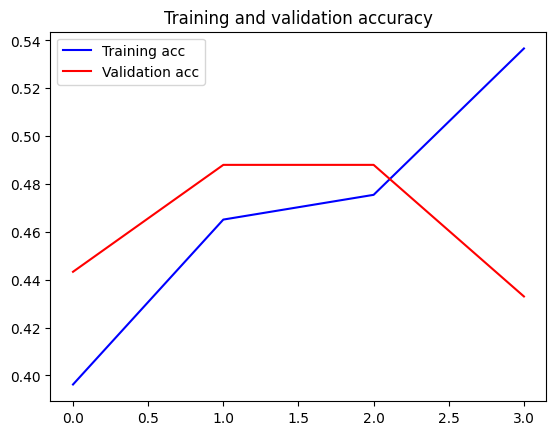

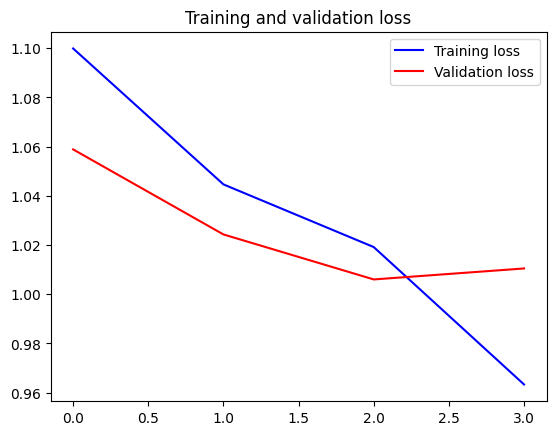

In [96]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Evaluasi Prediksi Sentimen

In [123]:
SENTIMENT_THRESHOLDS = (0.4, 0.7)

def decode_sentiment(score, include_neutral=True):
    if include_neutral:
        label = "Neutral"
        max_score = np.max(score)
        if max_score < 0.5:
            label = "Negative"
        else:
            label = "Positive"
        return label
    else:
        return "Negative" if np.max(score) < 0.5 else "Positive"

In [124]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    sequence = tokenizer.texts_to_sequences([text])
    # Memastikan panjang sekuens sesuai dengan panjang maksimum
    sequence = pad_sequences(sequence, maxlen=max_len)
    # Prediksi
    score = model.predict(sequence)[0]
    end_at = time.time()
    # Decode sentimen
    label = decode_sentiment(score, include_neutral=include_neutral)
    # Cetak hasil prediksi dan waktu yang diperlukan
    print("Sentimen:", label)
    print("Waktu prediksi:", end_at - start_at, "detik")

In [125]:
# Panggil fungsi predict dengan teks yang ingin Anda prediksi
predict("sumatera selatan asian game berdampak pd ekonomi langsung diprediksi mencapai triliun indonesia maju jokowi hebat")

1/1 [==============================] - 0s 50ms/step
Sentimen: Positive
Waktu prediksi: 0.1332378387451172 detik


## Confusion Matrix

### Mencari Urutan Label

In [127]:
from sklearn.preprocessing import LabelEncoder

# Membuat instance dari LabelEncoder
label_encoder = LabelEncoder()

# Mengubah label kelas menjadi angka berurutan
y_test_encoded = label_encoder.fit_transform(y_test)

# Menampilkan urutan angka yang dihasilkan
class_labels = label_encoder.classes_
class_indices = label_encoder.transform(class_labels)
class_order = sorted(zip(class_indices, class_labels))

for idx, label in class_order:
    print(f"Angka {idx} mewakili label kelas {label}")


Angka 0 mewakili label kelas 0
Angka 1 mewakili label kelas 1
Angka 2 mewakili label kelas 2


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [128]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.sentimen)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

1/1 [==============================] - 0s 163ms/step
CPU times: user 240 ms, sys: 17 ms, total: 257 ms
Wall time: 217 ms


In [131]:
import itertools

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

<ipython-input-131-32c9a2a7b192>:11: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


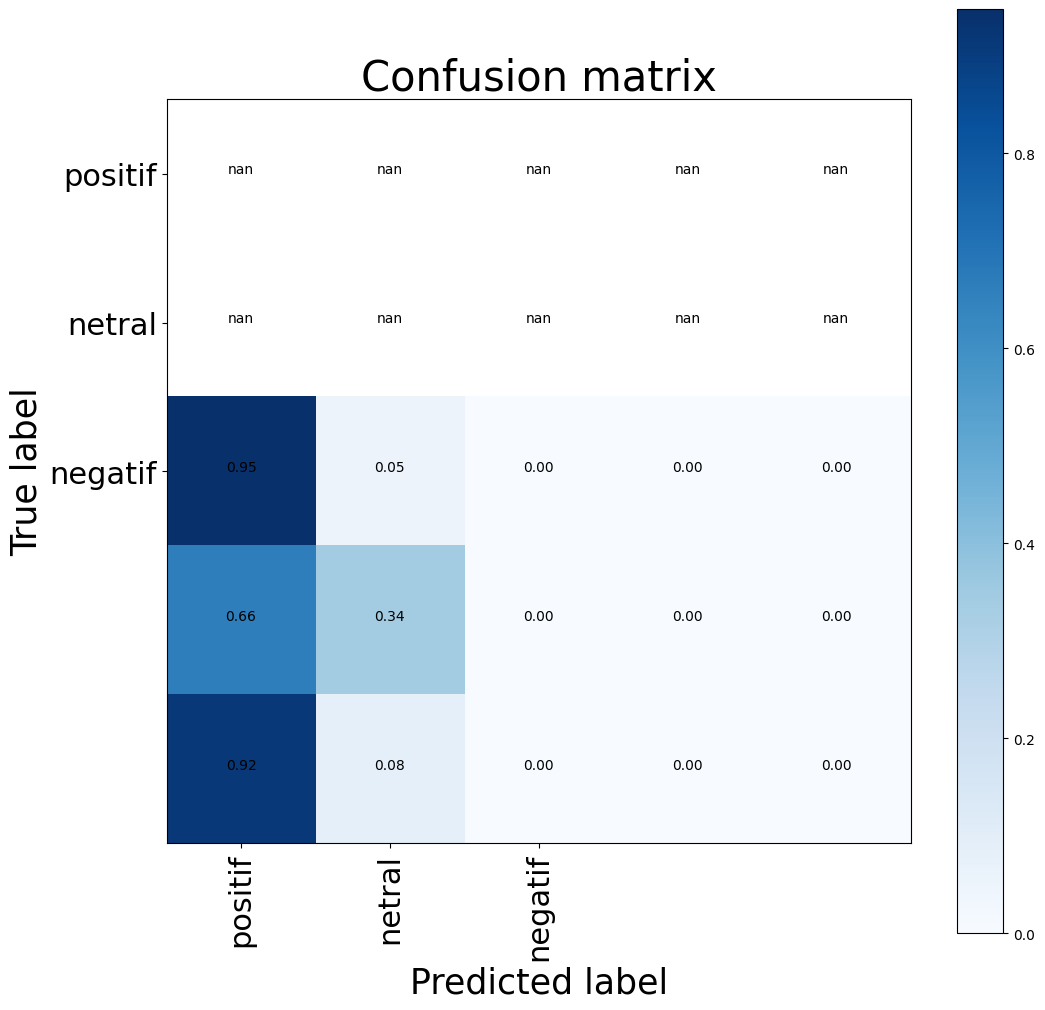

CPU times: user 706 ms, sys: 153 ms, total: 860 ms
Wall time: 1.17 s


In [133]:
%%time
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.sentimen.unique(), title="Confusion matrix")
plt.show()

## Classification Report

In [138]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       0.0
    Positive       0.00      0.00      0.00       0.0
     negatif       0.00      0.00      0.00     115.0
      netral       0.00      0.00      0.00     118.0
     positif       0.00      0.00      0.00     130.0

    accuracy                           0.00     363.0
   macro avg       0.00      0.00      0.00     363.0
weighted avg       0.00      0.00      0.00     363.0



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [136]:
print("LSTM Predict")
accuracy_score(y_test_1d, y_pred_1d)

LSTM Predict


0.0

# Kesimpulan

Beberapa kesimpulan yang dapat saya berikan dalam analisa ini :


Dari hasil analisa yang telah dilakukan menunjukan Sentimen penumpang terhadap maskapai British Airways menunjukan banyaknya penumpang memberikan feedback positif daripada negatif yaitu ...% feedback positif dan ...% feedback negatif.


Namun hasil analisa lainnya terlihat bahwa kata-kata yang sering muncul dalam feedback positif adalah "Ekonomi", "Jokowi", "Rakyat", dan "Gaji". Sementara itu, kata-kata yang sering muncul dalam feedback negatif adalah "Ekonomi", "Jokowi", "Prabowo", "Gaji", "Harga". Sehingga ini bisa menjadi perhatian kembali bagi tim bisnis untuk memperbaiki aspek - aspek dari feedback yang diberikan oleh penumpang